In [ ]:
%load_ext autoreload
%autoreload 2


In [1]:
import os
cwd = os.getcwd().replace("/note/experiments", "")
os.chdir(cwd)


In [79]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import xtools as xt
import json
import xsim
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
from collections import namedtuple


In [3]:
from qml.db import dpo as xdpo
from qml.db import target as xtarget
from qml.db.ml import MLDatasetGenerator
from qml.db.dpo.decoder import DPODataDecoder, DPOData
from qml.db.dpo.loader import DPODataBatch
from qml.model.gate import Gateset
from qml.model.unit import UnitManager, Unit
from qml.model.encoding import EncodingUnitManager
from qml.model.model import Model
from qml.optimizer import dpo as xdpopt
from qml.optimizer import evaluator as xeval
from qml.tools.random import XRandomGenerator
from qml.tools.sampler import CandidateSampler
from qml import optimizer as xoptim
from qml.tools.config import Config
# from qml.tools.validation import validate
from qml.tools.validation import get_base_qc
from qml.tools.experiment_tools import train_once, hard_copy, prepare_policy, plot_results, validate, generate_batch, soft_update

In [46]:
cf = Config("note/experiments/config.yaml")
seed = None

In [47]:
online_dpo_weight_filepath = "/Users/loutrebleu/workspace/qml/note/experiments/results/2025.04.14.195932/results_00730.pth"
online_cpo_weight_filepath = "/Users/loutrebleu/workspace/qml/note/experiments/results/2025.04.14.195932/results_00730.pth"

In [48]:
# build policies
policy_dpo, _, _, sampler_dpo = prepare_policy(cf)
policy_dpo.load_state_dict(torch.load(online_dpo_weight_filepath))
policy_cpo, _, _, sampler_cpo = prepare_policy(cf)
policy_cpo.load_state_dict(torch.load(online_cpo_weight_filepath))


<All keys matched successfully>

In [ ]:
rng = XRandomGenerator(seed)
gset = Gateset.set_num_qubits(cf.nq)

# target datasets
tfun = xtarget.PolynominalTargetFunctionGenerator(cf.qml.db.dim_polynomial, seed=rng.new_seed())
tgen = MLDatasetGenerator(tfun, seed=rng.new_seed())
Dqml = tgen.generate(cf.qml.db.size)
# Dqml = tgen.generate(5)

# prepare
base_model = get_base_qc(cf.nq, cf.qml.db.dim_input, cf.qml.db.dim_output, cf.shots)
weval = xeval.WaveletEvaluator(cf.wavelet, Dqml, wavelet_dim=cf.ocg.dim_wavelet)

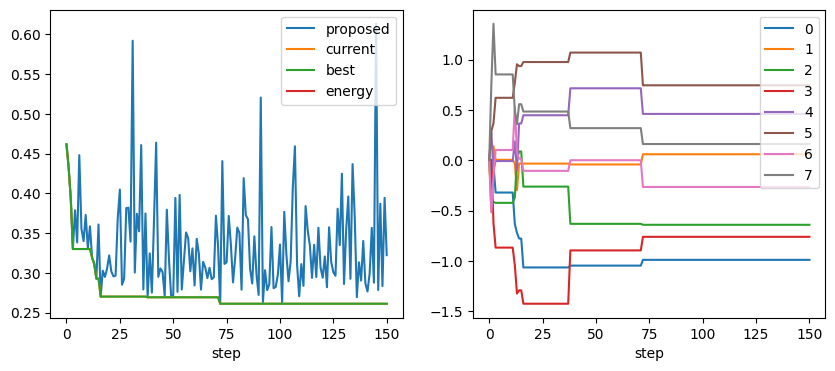

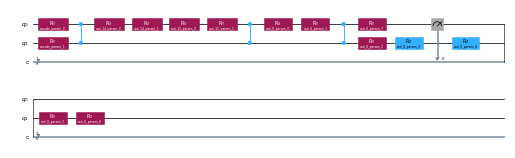

In [86]:
save_dir = xt.make_dirs_current_time("note/experiments/results")

# -==============================================
## DPO
policy = policy_cpo
sampler = sampler_cpo
base_model = get_base_qc(cf.nq, cf.qml.db.dim_input, cf.qml.db.dim_output, cf.shots)
model_dpo = Model(
    base_model.nq, base_model.nc,
    base_model.input_units,
    base_model.fixed_units,
    base_model.trainable_units,
)

tresults_dpo = []
# for round in range(1, cf.dpo.validation.num_rounds+1+2):
time_avons_dpo = time.time()
for round in tqdm(range(3)):
    # 1. measure the wavelet series
    wresult = weval(model_dpo.trainable_parameters, model_dpo)

    # 2. estimate the candidate unit
    wseries = wresult.powers
    candidate = sampler.sample(wseries)
    model_dpo.fix_trainable_units()

    # 3. updata model
    model_dpo = Model(
        base_model.nq, base_model.nc,
        base_model.input_units,
        base_model.fixed_units,
        candidate,
    )

    # 4. train the model
    optimizer = xoptim.LocalSearchOptimizer(Dqml)
    tresult = optimizer.optimize(model_dpo, cf.qml.num_train, verbose=False)
    tresults_dpo.append(tresult)
time_apres_dpo = time.time()

time_dpo = time_apres_dpo - time_avons_dpo
tres_dpo = pd.concat([tresult.result_energies for tresult in tresults_dpo], axis=0)
tres_dpo.step = np.arange(len(tres_dpo))
tres_dpo.to_csv(xt.join(save_dir, "dpo.csv"))
fig, ax = plt.subplots()
model_dpo.draw(ax)
plt.savefig(xt.join(save_dir, "dpo.png"))

# -==============================================
## CPO
policy = policy_dpo
sampler = sampler_dpo
base_model = get_base_qc(cf.nq, cf.qml.db.dim_input, cf.qml.db.dim_output, cf.shots)
model_cpo = Model(
    base_model.nq, base_model.nc,
    base_model.input_units,
    base_model.fixed_units,
    base_model.trainable_units,
)

tresults_cpo = []
# for round in range(1, cf.dpo.validation.num_rounds+1+2):
time_avons_cpo = time.time()
for round in tqdm(range(3)):
    # 1. measure the wavelet series
    wresult = weval(model_cpo.trainable_parameters, model_cpo)

    # 2. estimate the candidate unit
    wseries = wresult.powers
    candidate = sampler.sample(wseries)
    model_cpo.fix_trainable_units()

    # 3. updata model
    model_cpo = Model(
        base_model.nq, base_model.nc,
        base_model.input_units,
        base_model.fixed_units,
        candidate,
    )

    # 4. train the model
    optimizer = xoptim.LocalSearchOptimizer(Dqml)
    tresult = optimizer.optimize(model_cpo, cf.qml.num_train, verbose=False)
    tresults_cpo.append(tresult)

time_apres_cpo = time.time()

time_cpo = time_apres_cpo - time_avons_cpo
tres_cpo = pd.concat([tresult.result_energies for tresult in tresults_cpo], axis=0)
tres_cpo.step = np.arange(len(tres_cpo))
tres_cpo.to_csv(xt.join(save_dir, "cpo.csv"))
fig, ax = plt.subplots()
model_cpo.draw(ax)
plt.savefig(xt.join(save_dir, "cpo.png"))



# -==============================================
## random
# prepare
model_rnd = get_base_qc(cf.nq, cf.qml.db.dim_input, cf.qml.db.dim_output, cf.shots)
weval = xeval.WaveletEvaluator(cf.wavelet, Dqml, wavelet_dim=cf.ocg.dim_wavelet)

uman = UnitManager(2, 9)
unit = uman.generate_random_unit()

# policy = policy_dpo
# sampler = sampler_dpo
policy = policy_cpo
sampler = sampler_cpo
model_rnd = Model(
    base_model.nq, base_model.nc,
    base_model.input_units,
    base_model.fixed_units,
    unit
)

time_avons_rnd = time.time()
optimizer = xoptim.LocalSearchOptimizer(Dqml)
tresults_rnd = optimizer.optimize(model_rnd, cf.qml.num_train*3, verbose=True)
time_apres_rnd = time.time()

time_rnd = time_apres_rnd - time_avons_rnd
# tres_rnd = pd.concat([tresult.result_energies for tresult in tresults_rnd], axis=0)
# tres_rnd.step = np.arange(len(tres_rnd))
tresults_rnd.result_energies.to_csv(xt.join(save_dir, "rnd.csv"))
fig, ax = plt.subplots()
model_rnd.draw(ax)
plt.savefig(xt.join(save_dir, "rnd.png"))

In [84]:

tresults_rnd.result_energies.to_csv(xt.join(save_dir, "rnd.csv"))

In [68]:
tres_cpo = pd.concat([tresult.result_energies for tresult in tresults], axis=0)
tres_cpo.step = np.arange(len(tres_cpo))
          

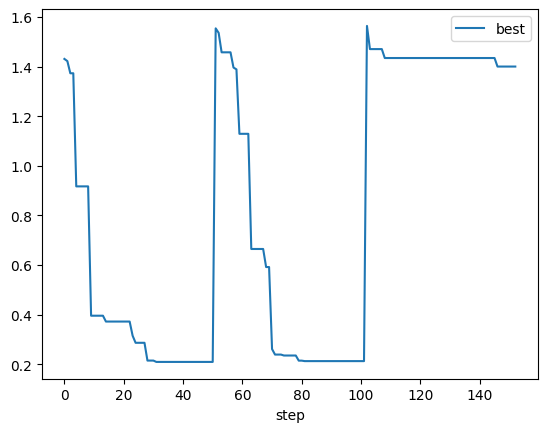

In [69]:
tres_cpo.plot("step", "best")
plt.savefig("cpo.png")

In [70]:
tres_cpo.to_csv("cpo.csv")

In [66]:
tres_dpo.best.min()

np.float64(0.24737803995945096)

In [71]:
tres_cpo.best.min()

np.float64(0.20923656327043602)

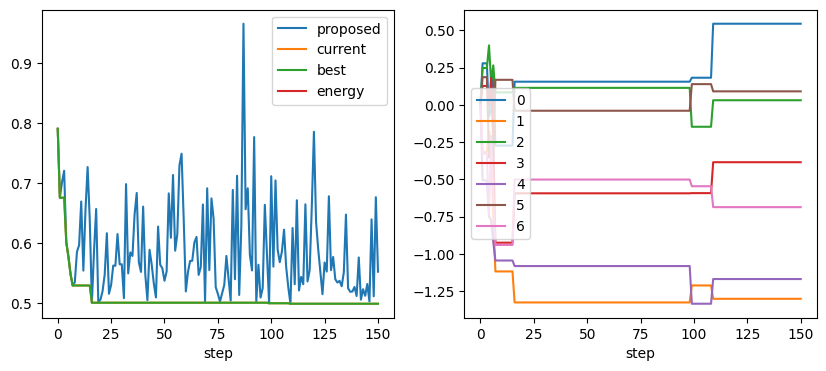

In [73]:
rng = XRandomGenerator(seed)
gset = Gateset.set_num_qubits(cf.nq)

# target datasets
tfun = xtarget.PolynominalTargetFunctionGenerator(cf.qml.db.dim_polynomial, seed=rng.new_seed())
tgen = MLDatasetGenerator(tfun, seed=rng.new_seed())
Dqml = tgen.generate(cf.qml.db.size)
# Dqml = tgen.generate(5)

# prepare
base_model = get_base_qc(cf.nq, cf.qml.db.dim_input, cf.qml.db.dim_output, cf.shots)
weval = xeval.WaveletEvaluator(cf.wavelet, Dqml, wavelet_dim=cf.ocg.dim_wavelet)

uman = UnitManager(2, 9)
unit = uman.generate_random_unit()

# policy = policy_dpo
# sampler = sampler_dpo
policy = policy_cpo
sampler = sampler_cpo
model = Model(
    base_model.nq, base_model.nc,
    base_model.input_units,
    base_model.fixed_units,
    unit
)

optimizer = xoptim.LocalSearchOptimizer(Dqml)
tresult = optimizer.optimize(model, cf.qml.num_train*3, verbose=True)


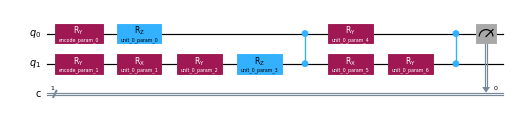

In [74]:
fig, ax = plt.subplots()
model.draw(ax)
plt.savefig("rnd.png")

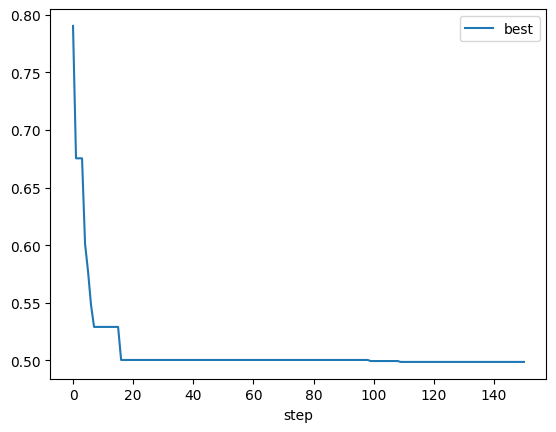

In [77]:
tres_rnd = tresult.result_energies
tres_rnd.to_csv("rnd.csv")
tres_rnd.plot("step", "best")
plt.savefig("end.png")